## Inversion recovery example

In this example, we will perform an inversion-recovery experiment on a Pyridine molecule, which is a great example showcasing the functionality of the Spinguin package. The simulation incorporates all NMR-active spins of the Pyridine molecule (all 5 protons and the quadrupolar nitrogen-14), and the performance is increased by utilizing the restricted Liouville space. The coherent interactions (Zeeman, isotropic shift, and $J$-coupling) as well as incoherent interactions (dipolar coupling, chemical shielding anisotropy, quadrupolar coupling, and scalar relaxation of the second kind) are included in the simulation.

### Imports

The first step is to import all the necessary modules. NumPy arrays are required for the input parameters and for storing the results, Matplotlib is used for plotting, and some functionality is imported from the Spinguin package.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from spinguin.spin_system import SpinSystem
from spinguin.hamiltonian import hamiltonian
from spinguin.relaxation import relaxation, thermalize
from spinguin.states import thermal_equilibrium, measure
from spinguin.propagation import propagator, pulse
from spinguin.basis import ZQ_basis, ZQ_filter

### Simulation parameters

We set the magnetic field (T), rotational correlation time (ps), temperature (K), time step (s) and the number of time steps.

In [39]:
field = 1
tau_c = 10e-12
temp = 295
time_step = 2e-3
nsteps = 50000

### Define the spin system

Next, we want to define the spin system. We assign the isotopes, chemical shifts (ppm), scalar couplings (Hz), XYZ coordinates (Å), shielding tensors (ppm), and EFG tensors (a.u.) as NumPy arrays. These are then given as an input when instantiating the spin system object. Maximum spin order is limited to 3 for improved performance.

In [40]:
isotopes = np.array(['1H', '1H', '1H', '1H', '1H', '14N'])
chemical_shifts = np.array([8.56, 8.56, 7.47, 7.47, 7.88, 95.94])
scalar_couplings = np.array([\
    [ 0,     0,      0,      0,      0,      0],
    [-1.04,  0,      0,      0,      0,      0],
    [ 4.85,  1.05,   0,      0,      0,      0],
    [ 1.05,  4.85,   0.71,   0,      0,      0],
    [ 1.24,  1.24,   7.55,   7.55,   0,      0],
    [ 8.16,  8.16,   0.87,   0.87,  -0.19,   0]
])
xyz = np.array([\
    [ 2.0495335, 0.0000000, -1.4916842],
    [-2.0495335, 0.0000000, -1.4916842],
    [ 2.1458878, 0.0000000,  0.9846086],
    [-2.1458878, 0.0000000,  0.9846086],
    [ 0.0000000, 0.0000000,  2.2681296],
    [ 0.0000000, 0.0000000, -1.5987077]
])
shielding = np.zeros((6, 3, 3))
shielding[5] = np.array([\
    [-406.20, 0.00,   0.00],
    [ 0.00,   299.44, 0.00],
    [ 0.00,   0.00,  -181.07]
])
efg = np.zeros((6, 3, 3))
efg[5] = np.array([\
    [0.3069, 0.0000,  0.0000],
    [0.0000, 0.7969,  0.0000],
    [0.0000, 0.0000, -1.1037]
])
spin_system = SpinSystem(isotopes, chemical_shifts, scalar_couplings, xyz, shielding, efg, max_spin_order=3)

### Calculate Hamiltonian and relaxation superoperators

Our goal is to perform the time evolution of the spin system under the NMR interactions described by the Liouvillian. Therefore, we want to calculate the Hamiltonian and relaxation superoperators. We choose to include the scalar relaxation of the second kind for completeness, even though its effect at the field of 1 T is insignificant.

In [41]:
H = hamiltonian(spin_system, field)
R = relaxation(spin_system, H, field, tau_c, include_sr2k=True)

Starting to construct the Hamiltonian.
Hamiltonian constructed.
Elapsed time: 0.5059061050415039 seconds.
Starting to construct the relaxation superoperator.
Processing l:1, q:0
Processing l:1, q:1
Processing l:2, q:0
DD: 1-0
DD: 2-0
DD: 2-1
DD: 3-0
DD: 3-1
DD: 3-2
DD: 4-0
DD: 4-1
DD: 4-2
DD: 4-3
DD: 5-0
DD: 5-1
DD: 5-2
DD: 5-3
DD: 5-4
CSA: 5-None
Q: 5-None
Processing l:2, q:1
DD: 1-0
DD: 2-0
DD: 2-1
DD: 3-0
DD: 3-1
DD: 3-2
DD: 4-0
DD: 4-1
DD: 4-2
DD: 4-3
DD: 5-0
DD: 5-1
DD: 5-2
DD: 5-3
DD: 5-4
CSA: 5-None
Q: 5-None
Processing l:2, q:2
DD: 1-0
DD: 2-0
DD: 2-1
DD: 3-0
DD: 3-1
DD: 3-2
DD: 4-0
DD: 4-1
DD: 4-2
DD: 4-3
DD: 5-0
DD: 5-1
DD: 5-2
DD: 5-3
DD: 5-4
CSA: 5-None
Q: 5-None
Processing scalar relaxation of the second kind.
Relaxation superoperator constructed.
Elapsed time: 3.1919167041778564 seconds.


### Thermal equilibrium

Initial condition in an inversion-recovery experiment is the thermal equilibrium. We create a state vector corresponding to the thermal equilibrium.

In [42]:
rho = thermal_equilibrium(spin_system, temp, field)

### Apply 180-degree pulse

Inversion recovery begins with an 180-degree pulse. We first create the pulse, which is essentially a time propagator, which is applied by multiplying to the state vector. The pulse is given along the $x$-axis to each proton (spins with indices from 0 to 4).

In [43]:
pul_180 = pulse(spin_system, 'I_x', [0, 1, 2, 3, 4], angle=180)
rho = pul_180 @ rho

### Change to zero-quantum basis (optional)

This step is optional, but it will decrease the computational cost, as the dimensions of the matrices become smaller. We know that the state after the the initial pulse contains only zero-quantum terms. In this case, the evolution under the Liouvillian will not cause any transitions that would result in different coherence orders. Therefore, we may restrict ourselves into a basis set that only contains the zero-quantum terms without sacrificing accuracy. Note that the above step must be performed before the conversion to zero-quantum basis, as the pulse along $x$-axis is a mixture of zero- and double-quantum coherence.

We first apply the zero-quantum basis to our spin system, and subsequently convert the superoperators and the state vector into zero-quantum basis.

In [44]:
ZQ_basis(spin_system)
H = ZQ_filter(spin_system, H)
R = ZQ_filter(spin_system, R)
rho = ZQ_filter(spin_system, rho)

Constructing the zero-quantum basis.
Zero-quantum basis created.
Elapsed time: 0.0 seconds.
Applying zero-quantum coherence filter.
Zero-quantum coherence filter applied.
Elapsed time: 0.0 seconds.
Applying zero-quantum coherence filter.
Zero-quantum coherence filter applied.
Elapsed time: 0.0 seconds.
Applying zero-quantum coherence filter.
Zero-quantum coherence filter applied.
Elapsed time: 0.0 seconds.


### Thermalize the relaxation superoperator

When the relaxation superoperator is created, it is not thermalized. This means that the relaxation superoperator drives the spin system towards the unit state, which is not what we want in an inversion recovery experiment. We want the relaxation superoperator to drive the spin system back to equilibrium once the state has been altered by the 180-degree pulse. Therefore, we must apply thermalization to the relaxation superoperator.

In [45]:
R = thermalize(spin_system, R, field, temp)

### Construct the time propagator

We are now ready to construct the time propagator which will be used to drive the spin system forward in time.

In [46]:
P = propagator(time_step, H, R)

Building the time propagator.
Propagator density: 0.9442029638304581
Density exceeds threshold. Converting to NumPy.
Propagator constructed.
Elapsed time: 0.5075874328613281 seconds.


### Initialize an empty array for storing the results

In inversion recovery, we are interested in measuring the magnetizations of the spins at various time intervals. In experiments, this is done by applying a 90-degree pulse and recording the free induction decay. In simulations, this is not required, as we can directly observe the magnetization by "measuring" the expectation value of the $z$-magnetization of each spin at each time interval. To store the magnetizations, we first initialize a NumPy array with the dimensions corresponding to the number of time steps and the number of protons in our spin system.

In [47]:
magnetizations = np.zeros((nsteps, 5), dtype=complex)

### Perform the time evolution

Finally, we are ready to perform the time evolution. We loop over the number of time steps, and, within each time step, we propagate the system forward in time and perform the measurement for every proton (again, protons have the indices from 0 to 4 in our system).

In [48]:
for step in range(nsteps):
    rho = P @ rho

    for idx in [0, 1, 2, 3, 4]:
        magnetizations[step, idx] = measure(spin_system, rho, 'I_z', idx)

### Plot the results

Congratulations! The simulation is now completed. The results have been stored in the magnetizations array. One can now save the results as CSV, perform additional analysis on the results immediately, or plot the results. We will plot and show the results.

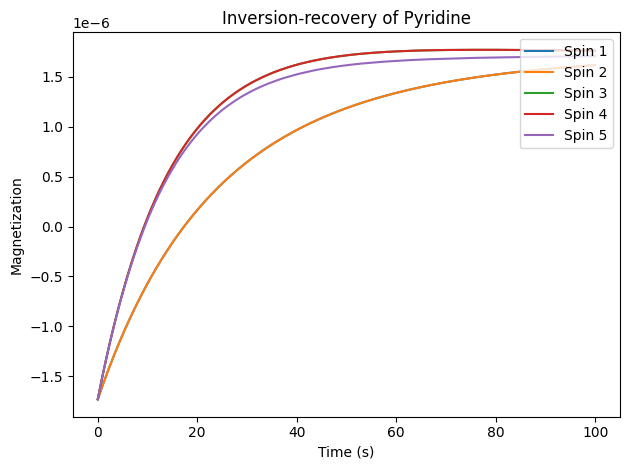

<Figure size 640x480 with 0 Axes>

In [49]:
t = np.linspace(time_step, nsteps*time_step, nsteps)
for i in [0, 1, 2, 3, 4]:
    plt.plot(t, np.real(magnetizations[:,i]), label=f"Spin {i+1}")
plt.legend(loc="upper right")
plt.xlabel("Time (s)")
plt.ylabel("Magnetization")
plt.title("Inversion-recovery of Pyridine")
plt.tight_layout()
plt.show()
plt.clf()